collecting data using API:

In [2]:
import requests
import pandas as pd

We used the TMDb API to retrieve the top 550 movies based on ratings. First, we fetched movie IDs using the top-rated movies endpoint, handling pagination to gather the required number of entries. Then, for each movie ID, we retrieved detailed information such as title, release year, IMDb rating, vote count, genres, and runtime. The collected data was stored in a pandas DataFrame, with a 'Rank' column added based on the index. Finally, we structured and saved the dataset as a CSV file (Raw_Data.csv) for further analysis.

In [6]:


# TMDb API key
api_key = '365978475adad9f2f69fa506de43a2ed'

# Function to fetch movie details from TMDb API
def fetch_movie_data(movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&language=en-US"
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            return {
                "Title": data.get("title"),
                "Year": data.get("release_date", "").split("-")[0],  # Get the release year
                "IMDb Rating": data.get("vote_average"),
                "Votes": data.get("vote_count"),
                "Genre": ', '.join([genre['name'] for genre in data.get("genres", [])]),
                "Runtime": f"{data.get('runtime', 0)} min"
            }
        except ValueError:
            print(f"Error decoding JSON for movie ID {movie_id}")
    else:
        print(f"Request failed for movie ID {movie_id}. Status code: {response.status_code}")
    return None

# Function to fetch the list of top-rated movies from TMDb
def fetch_top_rated_movies(limit=550):
    all_movie_ids = []
    page = 1
    while len(all_movie_ids) < limit:
        url = f"https://api.themoviedb.org/3/movie/top_rated?api_key={api_key}&language=en-US&page={page}"
        response = requests.get(url)

        if response.status_code == 200:
            try:
                data = response.json()
                # Add movies from this page to the list, ensuring we do not exceed the limit
                all_movie_ids.extend([movie['id'] for movie in data['results']])
                if len(all_movie_ids) >= limit:
                    break
                page += 1
            except ValueError:
                print("Error decoding JSON for top-rated movies")
        else:
            print(f"Request failed for page {page}. Status code: {response.status_code}")
            break
    return all_movie_ids[:limit]  # Limit the result to exactly 'limit' movies

# Get the list of top 550 movie IDs
movie_ids = fetch_top_rated_movies(limit=550)

# Create an empty list to store movie data
movie_data = []

# Loop through the list of movie IDs and fetch data for each movie
for movie_id in movie_ids:
    movie_info = fetch_movie_data(movie_id)
    if movie_info:
        movie_data.append(movie_info)

# Convert the movie data list into a pandas DataFrame
df = pd.DataFrame(movie_data)

# Add the 'Rank' column, based on the index of the DataFrame
df['Rank'] = df.index + 1  # Adding 1 to index for rank starting from 1

# Reorder columns to put 'Rank' first and remove 'TMDb ID'
df = df[['Rank', 'Title', 'Year', 'IMDb Rating', 'Votes', 'Genre', 'Runtime']]

# Display the DataFrame
print(df)

# save the DataFrame to a CSV file
df.to_csv("Raw_Data.csv", index=False)


     Rank                         Title  Year  IMDb Rating  Votes  \
0       1      The Shawshank Redemption  1994        8.708  27655   
1       2                 The Godfather  1972        8.688  20970   
2       3         The Godfather Part II  1974        8.570  12656   
3       4              Schindler's List  1993        8.567  16109   
4       5                  12 Angry Men  1957        8.546   8847   
..    ...                           ...   ...          ...    ...   
545   546              A Bag of Marbles  2017        7.822    856   
546   547  Fantozzi: White Collar Blues  1975        7.822    827   
547   548              Infernal Affairs  2002        7.822   1660   
548   549                          1900  1976        7.822    631   
549   550                  The Specials  2019        7.821    915   

                                       Genre  Runtime  
0                               Drama, Crime  142 min  
1                               Drama, Crime  175 min  
2  

We performed data preprocessing on the raw movie dataset to ensure quality and consistency. First, we removed duplicate rows and handled missing values by dropping entries with essential missing data. Then, we converted 'Year', 'IMDb Rating', and 'Votes' to appropriate numeric types for accurate analysis. The 'Genre' column was cleaned by stripping extra spaces, and 'Runtime' was transformed into an integer format by removing the "min" text. Finally, we saved the cleaned dataset as "Cleaned_Data.csv" for further use.

In [8]:
#Preprocessing
import pandas as pd

# Load the raw movie dataset
df = pd.read_csv("/content/Raw_Data.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Handle missing values (drop rows with missing essential data)
df = df.dropna(subset=["Title", "Year", "IMDb Rating", "Votes", "Genre", "Runtime"])

# Convert 'Year' to integer
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").fillna(0).astype(int)

# Convert 'IMDb Rating' and 'Votes' to appropriate numeric types
df["IMDb Rating"] = pd.to_numeric(df["IMDb Rating"], errors="coerce").fillna(0)
df["Votes"] = pd.to_numeric(df["Votes"], errors="coerce").fillna(0)

# Clean 'Genre' column by removing extra spaces and ensuring it's properly formatted
df["Genre"] = df["Genre"].str.strip()

# Convert 'Runtime' to numeric format (remove "min" and convert to integer)
df["Runtime"] = df["Runtime"].str.replace(" min", "", regex=True)
df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce").fillna(0).astype(int)

# Save the cleaned dataset
df.to_csv("Cleaned_Data.csv", index=False)

# Display the first few rows of the cleaned data
print(df.head())

   Rank                     Title  Year  IMDb Rating  Votes  \
0     1  The Shawshank Redemption  1994        8.708  27655   
1     2             The Godfather  1972        8.688  20970   
2     3     The Godfather Part II  1974        8.570  12656   
3     4          Schindler's List  1993        8.567  16109   
4     5              12 Angry Men  1957        8.546   8847   

                 Genre  Runtime  
0         Drama, Crime      142  
1         Drama, Crime      175  
2         Drama, Crime      202  
3  Drama, History, War      195  
4                Drama       97  


In [9]:
%pip install seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
movies = pd.read_csv("Cleaned_Data.csv")

We analyzed the correlation between Rank and Votes to understand their relationship. First, we extracted the relevant columns and computed the correlation matrix using .corr(). Then, we visualized the correlation using a heatmap with annotations for clarity. This helps identify whether higher-ranked movies tend to have more votes, providing insights into audience engagement.

           Rank     Votes
Rank   1.000000 -0.270741
Votes -0.270741  1.000000


<Axes: title={'center': 'Correlation between Rank and Voting'}>

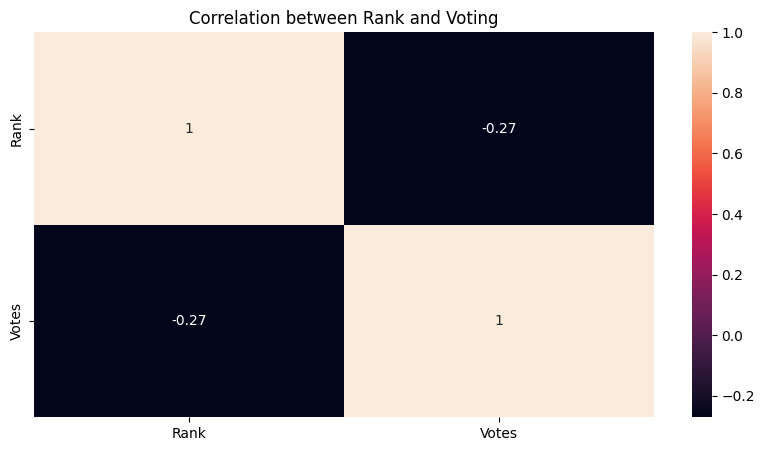

In [10]:
rank_votes_data = movies[['Rank','Votes']]
correlation = rank_votes_data.corr()
print(correlation)
plt.figure(figsize=(10,5))
plt.title('Correlation between Rank and Voting')
sns.heatmap(correlation, annot=True)

We analyzed the impact of genre diversity on IMDb ratings and votes. First, we created a new column, 'Multiple_Genres', which identifies whether a movie belongs to multiple genres. After cleaning missing values, we used box plots to compare IMDb ratings and vote counts between single-genre and multi-genre movies. This visualization helps identify whether multi-genre films receive higher ratings or more votes than single-genre films.

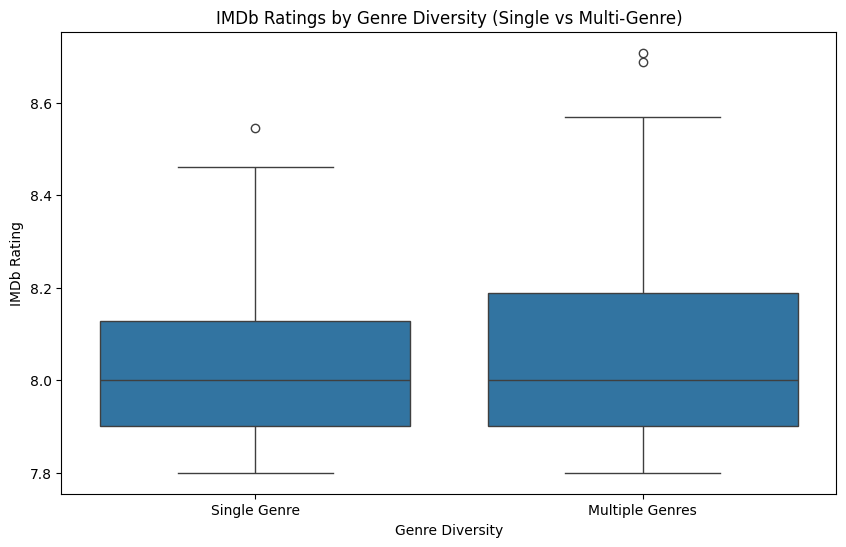

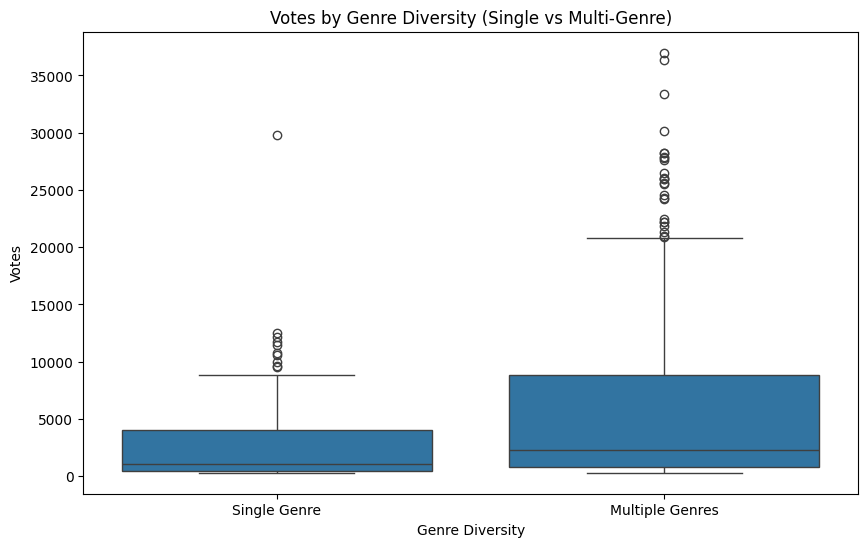

In [11]:
movies['Genre'] = movies['Genre'].astype(str)
movies['Multiple_Genres'] = movies['Genre'].apply(lambda x: ',' in x)
movies_clean = movies.dropna(subset=['IMDb Rating', 'Votes'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_clean, x='Multiple_Genres', y='IMDb Rating')
plt.title('IMDb Ratings by Genre Diversity (Single vs Multi-Genre)')
plt.xlabel('Genre Diversity')
plt.ylabel('IMDb Rating')
plt.xticks([0, 1], ['Single Genre', 'Multiple Genres'])
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_clean, x='Multiple_Genres', y='Votes')
plt.title('Votes by Genre Diversity (Single vs Multi-Genre)')
plt.xlabel('Genre Diversity')
plt.ylabel('Votes')
plt.xticks([0, 1], ['Single Genre', 'Multiple Genres'])
plt.show()


We analyzed the correlation between movie runtime and IMDb rating to see if longer movies tend to have higher ratings. First, we extracted the relevant columns and computed the correlation matrix. Then, we visualized the correlation using a heatmap with annotations for clarity. This helps in understanding the relationship between a movie’s length and its audience reception.

              Runtime  IMDb Rating
Runtime      1.000000     0.162596
IMDb Rating  0.162596     1.000000


<Axes: title={'center': 'Correlation between Movie Runtime and IMDb Rating'}>

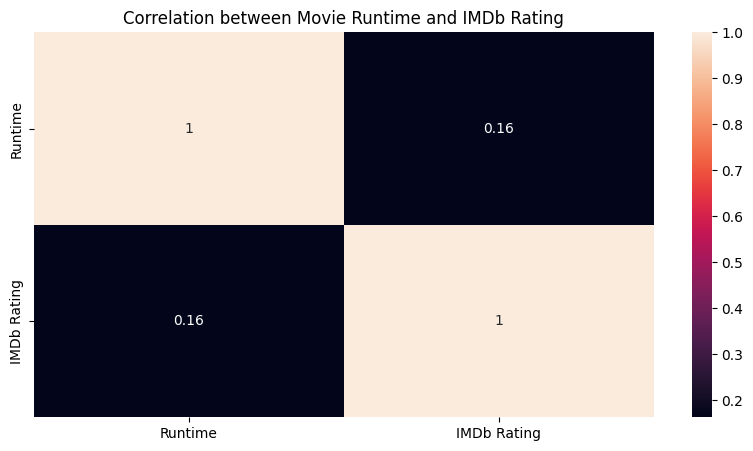

In [12]:
runtime_rating_data = movies[['Runtime', 'IMDb Rating']]
correlation = runtime_rating_data.corr()
print(correlation)
plt.figure(figsize=(10,5))
plt.title('Correlation between Movie Runtime and IMDb Rating')
sns.heatmap(correlation, annot=True)

We analyzed the **average IMDb ratings** of movies from the **15 most recent years** in the dataset. First, we identified the **latest 15 years**, then filtered movies released in those years. We grouped the data by **year** and calculated the **average IMDb rating** for each. Finally, we visualized the trend using a **bar chart**, with data labels on top of each bar for clarity. This helps in understanding how movie ratings have evolved over recent years.

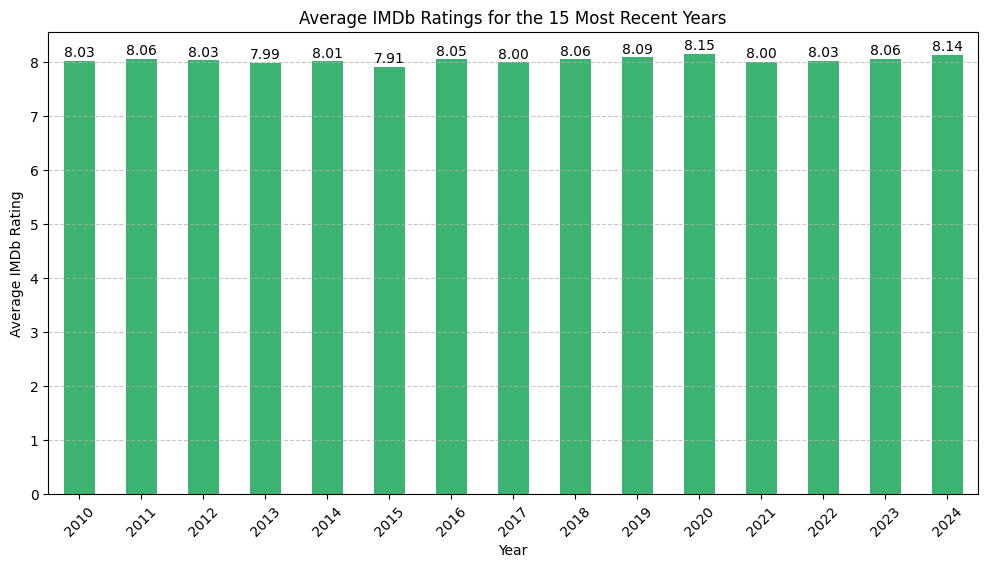

In [13]:
# Identify the 15 most recent years in the dataset
recent_years = movies['Year'].dropna().unique()  # Remove any NaN values if present
recent_years = sorted(recent_years, reverse=True)[:15]  # Get the 15 most recent years

# Filter data for the 15 most recent years
recent_movies = movies[movies['Year'].isin(recent_years)]

# Group by Year and calculate average IMDb Rating
avg_rating_recent_years = recent_movies.groupby('Year')['IMDb Rating'].mean()

# Sort years in chronological order for better visualization
avg_rating_recent_years = avg_rating_recent_years.sort_index()

# Bar plot to show the average IMDb Ratings for the 15 most recent years
plt.figure(figsize=(12, 6))
avg_rating_recent_years.plot(kind='bar', color='mediumseagreen')
plt.title('Average IMDb Ratings for the 15 Most Recent Years')
plt.xlabel('Year')
plt.ylabel('Average IMDb Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for clarity

# Add data labels on top of each bar
for index, value in enumerate(avg_rating_recent_years):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()


We analyzed the relationship between **movie genres** and **IMDb rating ranges**. First, we cleaned the **'Genre'** column to ensure consistent naming and identified the **top 20 most common genres**. Then, we categorized movies into **rating ranges** (1-4, 5-6, 7-8, 9-10) and created a **genre vs. rating matrix** using a cross-tabulation. Finally, we visualized this data using a **heatmap**, highlighting how different genres distribute across IMDb rating ranges. This helps in understanding which genres tend to receive higher or lower ratings.

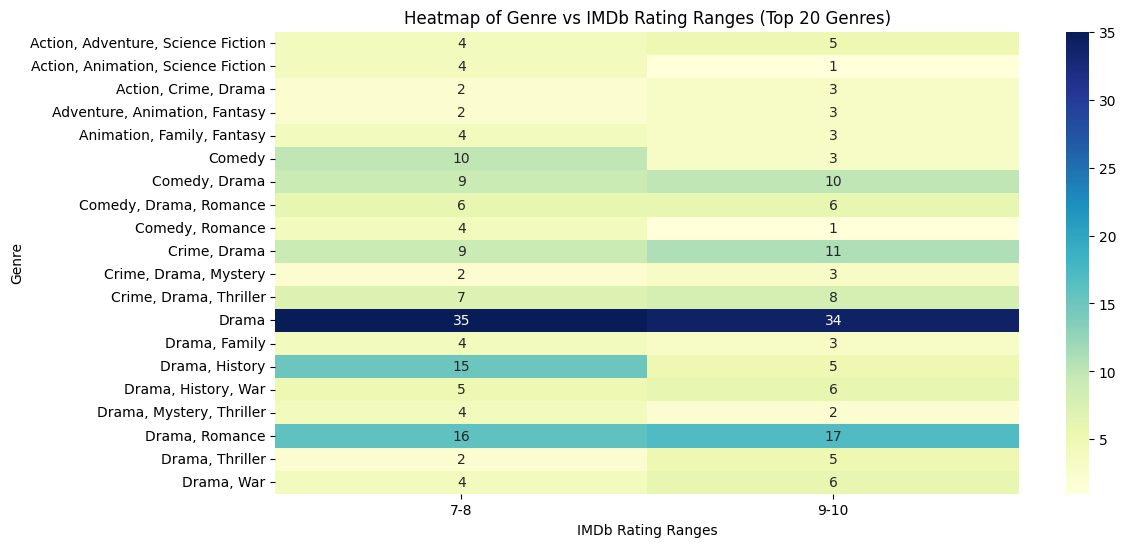

In [14]:
# Clean the 'Genre' column to ensure consistent naming
movies['Genre_Clean'] = movies['Genre'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# Get the top 20 most common genres
top_genres = movies['Genre_Clean'].value_counts().head(20).index

# Filter the data to only include top genres
filtered_movies = movies[movies['Genre_Clean'].isin(top_genres)].copy()  # Make a copy to avoid SettingWithCopyWarning

# Create the 'Rating_Range' column using .loc
filtered_movies['Rating_Range'] = pd.cut(filtered_movies['IMDb Rating'], bins=[0, 4, 6, 8, 10], labels=['1-4', '5-6', '7-8', '9-10'])

# Create a genre vs. rating matrix
genre_matrix = pd.crosstab(filtered_movies['Genre_Clean'], filtered_movies['Rating_Range'])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(genre_matrix, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title('Heatmap of Genre vs IMDb Rating Ranges (Top 20 Genres)')
plt.xlabel('IMDb Rating Ranges')
plt.ylabel('Genre')
plt.show()
